In [110]:
from IPython.display import display, Image
import requests
import IPython.display as ipd
import collections
import datetime
# import fluidsynth
from midi2audio import FluidSynth
import glob
import numpy as np
import pathlib
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pretty_midi
import seaborn as sns
import tensorflow as tf

from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

# Tomb added
import random
import time

In [111]:
#Download Chorales
data_dir = pathlib.Path('/Volumes/MAGIC1/CS50/myMusicGen/data/chorales')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'midi',
      origin='https://github.com/jamesrobertlloyd/infinite-bach/tree/master/data/chorales/midi',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 498


In [112]:
class UnsupportedMidiFileException(Exception):
  "Unsupported MIDI File"

In [113]:
"""Tomb made a pretty useful function"""
def check_pianoroll_dim(pianoroll):
        rows = len(pianoroll)  # This gives the number of rows
        columns = len(pianoroll[0])  # This assumes all rows have the same length

        print("Number of rows:", rows) # represents sequence length
        print("Number of columns:", columns) # represents the 4 octave range in midi 36-83
        print("Total dimesions of this pianoroll is", rows*columns)

In [115]:
def read_midi(filename, sop_alto, seqlen):
  
  def get_pianoroll(midi, nn_from, nn_thru, seqlen, tempo):
    pianoroll = midi.get_piano_roll(fs=2*tempo/60) # shape(128, 1262) This is the core line which makes this matrix based on 8th note
    if pianoroll.shape[1] < seqlen:
        raise UnsupportedMidiFileException

    pianoroll = pianoroll[nn_from:nn_thru, 0:seqlen] # (48, 64) Pinoroll's value still NOT binary since it has velocity
    
    binary_pianoroll = np.heaviside(pianoroll, 0) # converting as a binary matrix
    transposed_pianoroll = np.transpose(binary_pianoroll) #(64, 48)
    # transposed_pianoroll = np.transpose(pianoroll)
    # return binary_pianoroll
    return transposed_pianoroll # type numpy.ndarray

  def add_rest_nodes(pianoroll):  # If all the elemets are zero, the rest node says 1, else 0
    count_ones = np.count_nonzero(pianoroll == 1)
    count_zeros = np.count_nonzero(pianoroll == 0)
  
    #"There is only one '1' and the rest are '0's in the array."
    if count_ones == 1 and count_zeros == pianoroll.size - 1: # pinoroll size 3072
        rests = 1 - np.sum(pianoroll, axis=1)
        rests = np.expand_dims(rests, 1)
        return np.concatenate([pianoroll, rests], axis=1)
    
    #"All elements in the array are '0's."
    elif count_zeros == pianoroll.size:
        rests = 1 - np.sum(pianoroll, axis=1)
        rests = np.expand_dims(rests, 1)
        return np.concatenate([pianoroll, rests], axis=1)
    
    #"There are either multiple '1's or different values in the array."
    else:
        total_sum = np.sum(pianoroll, axis=1)
        rests = total_sum-total_sum 
        rests = np.expand_dims(rests, 1)
        return np.concatenate([pianoroll, rests], axis=1)
  
  
  # read midi file
  midi = pretty_midi.PrettyMIDI(filename)

  # An Exception error is thrown if there is a modulation(key change)
  if len(midi.key_signature_changes) !=1:
    raise UnsupportedMidiFileException

  # Modulate the given key to C major or C minor
  key_number = midi.key_signature_changes[0].key_number
  # transpose_to_c(midi, key_number)

  # Get Major key(keynode=0) or Minor key(keynode=1)
  keymode = np.array([int(key_number / 12)])

  # The Exception error thrown when tempo changes
  tempo_time, tempo = midi.get_tempo_changes()
  if len(tempo) != 1:
    raise UnsupportedMidiFileException
  if sop_alto:
    # The exception thrown if there are less than 2 parts
    if len(midi.instruments) < 2:
      raise UnsupportedMidiFileException
    # Get pianoRoll returns numpy.ndarray
    pr_s = get_pianoroll(midi.instruments[0], 36, 84, seqlen, tempo[0])
    pr_a = get_pianoroll(midi.instruments[1], 36, 84, seqlen, tempo[0])
    pr_b = get_pianoroll(midi.instruments[2], 36, 84, seqlen, tempo[0])
    wholePart = get_pianoroll(midi, 36, 84, seqlen, tempo[0])
    
    
    sop_w_rest = add_rest_nodes(pr_s) 
    alt_w_rest = add_rest_nodes(pr_a)
    bass_w_rest = add_rest_nodes(pr_b)
    wholePart_w_rest = add_rest_nodes(wholePart)
    
    # return pr_s, pr_a, pr_b, keymode
    # print("whole_Part_w_rest!!",wholePart_w_rest.shape)
    return sop_w_rest, alt_w_rest, bass_w_rest, wholePart_w_rest, keymode # All numpy.ndarray including keymode  

  # else:
  #   #Get a pianoroll which gathered all the parts
  #   pr = get_pianoroll(midi, 36, 84, seqlen, tempo[0])
  #   return pr, keymode

  # Tomb added  
  # pr = get_pianoroll(midi, 36, 84, seqlen, tempo[0])
  # # pr_w_rest = add_rest_nodes(pr)
  # # print(pr_w_rest)
  # # return pr_w_rest, keymode
  # return pr, keymode

In [141]:
"""Get the ingredients. 
Make the data(i.e manipulate the model as you tell it what you want) here for predict the 3rd note with given (x1,x2). 
Make list1 that has (xn, xn+1) pair elements 
and list2 which has (xn+2) elements"""

np.set_printoptions(threshold=np.inf) # Show the entire print, esp Matrix

x_all = [] #(30690, 2) Total dim is 61380
y_all = [] # 30690     Total dim is 30690 
files = [] # Number of files 498 but for collected files, there are 3 files that SKIPPED so we'll only see 495 files. E.g (495, int, int)
# keymodes = [] 

raw_seq_length =64

# repeat the process with all the midi files
for file in glob.glob(str(data_dir/"**/*.mid*")):
  files.append(file)
  try:
    # make a window to get sequence pairs (Xn, Xn+1) -> Xn+2
    sop_data, alt_data, bass_data, whole_part, keymode = read_midi(file, sop_alto=True, seqlen=raw_seq_length)
    desiredData = whole_part
    for i in range(len(desiredData)-2): # range(0, 62)
      # print(desiredData[i:i+2])
      # print("------------")
      # Get (x1,x2) and (x3)vectors  
      input_sequence = desiredData[i:i+2]
      output_target = desiredData[i+2]

    # <These code are getting each "note", not a vector  
    # for song in alt_data[1]: # sops_data shape (49, 64)
    #   print(song)
    #   for i in range(len(song)-2): # range(0, 62)
    #     input_sequence = song[i:i+2] # (Xn, Xn +1). print [0. 0.]  shape (2,)
    #     output_target = song[i+2] # Xn + 2. print 0.0  shape ()
        
      x_all.append(input_sequence)
      y_all.append(output_target)

  # throw exception for midi data which can not be used
  except UnsupportedMidiFileException:
    print("nah")

n_notes = len(x_all) # 1503810
print(check_pianoroll_dim(x_all)) 
print(len(y_all))
# print("Number of files",len(files))
# print("n_notes!",n_notes)

nah
nah
nah
Number of rows: 30690
Number of columns: 2
Total dimesions of this pianoroll is 61380
None
30690


#### Data preparation
-Convert to np.ndarray<br>
-Extract train and test data<br>
-Reshape(flatten) arrays to send to NNs<br>

In [142]:
input_data = np.array(x_all) # shape (30690, 2, 49) 
output_data = np.array(y_all) # shape (30690, 49)  <class 'numpy.ndarray'>

i_train, i_test = train_test_split(range(len(input_data)),test_size=int(len(input_data)/2)) 
# i_train len15345 type<list>: Inside [15340, 18372, 14977, 4270, 15527, 8407..// i_test len15345 type<list>: Inside [14555, 13355, 16794, 2034, 22187,..
x_train = input_data[i_train] # <'numpy.ndarray'> shape (15345, 2, 49) [[[0. 0...  This operation extracts rows from input_data specified by the indices present in i_train.
x_test = input_data[i_test] # <'numpy.ndarray'> shape (15345, 2, 49) [[[0. 0... For example, if i_train contains [0, 2, 4], input_data[i_train] will extract rows 0, 2, and 4 from input_data.

y_train = output_data[i_train] # shape (15345, 49) [[0. 0. 0. ..
y_test = output_data[i_test] # shape (15345, 49) [[0. 0. 0. ..

# <<<reshape>>>
x_train_reshaped = x_train.reshape(-1,2, 49)  # Reshape to sequences of 2 elements
x_test_reshaped = x_test.reshape(-1, 2, 49)
# Reshape y_train and y_test to match the output shape
y_train_reshaped = y_train.reshape(-1, 49)  # Reshape to target for each sequence
y_test_reshaped = y_test.reshape(-1, 49)

# print("x_train",x_train.shape)
# print("y_train",y_train.shape)
# print("x_train_reshaped",x_train_reshaped.shape)
# print("y_train_reshaped",y_train_reshaped.shape)

In [143]:
# print(check_pianoroll_dim(x_train))
# print(check_pianoroll_dim(y_train))
seq_length = x_train.shape[1] #int 2 # How many sequences for input features
pitch_range = 49
# print(pitch_range)
# print(x_train[:10])

In [144]:
# Create an LSTM model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64, input_shape=(seq_length, pitch_range)))  # Input shape corresponds to the reshaped data
model.add(tf.keras.layers.Dense(pitch_range, activation='sigmoid'))  # Adjust the output units and activation based on your problem

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Adjust loss and metrics


In [145]:
# Train the model

callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath="./training_checkpoints/ckpt_{epoch}",
        save_weights_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="loss",
        patience=5,
        verbose=1,
        restore_best_weights=True
    )]

epochs = 50
batch_size = 32

model.evaluate(x_train, y_train, return_dict=True)

history = model.fit(
    x_train, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    validation_data=(x_test, y_test))

# model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

480/480 [==============================] - 1s 520us/step - loss: 0.6921 - accuracy: 0.0508
Epoch 1/50
480/480 [==============================] - 2s 2ms/step - loss: 0.2793 - accuracy: 0.0066 - val_loss: 0.2146 - val_accuracy: 0.0066
Epoch 2/50
480/480 [==============================] - 1s 1ms/step - loss: 0.2019 - accuracy: 0.0079 - val_loss: 0.1925 - val_accuracy: 0.0113
Epoch 3/50
480/480 [==============================] - 1s 2ms/step - loss: 0.1860 - accuracy: 0.0150 - val_loss: 0.1806 - val_accuracy: 0.0148
Epoch 4/50
480/480 [==============================] - 1s 1ms/step - loss: 0.1765 - accuracy: 0.0215 - val_loss: 0.1732 - val_accuracy: 0.0212
Epoch 5/50
480/480 [==============================] - 1s 2ms/step - loss: 0.1706 - accuracy: 0.0295 - val_loss: 0.1688 - val_accuracy: 0.0251
Epoch 6/50
480/480 [==============================] - 1s 2ms/step - loss: 0.1669 - accuracy: 0.0329 - val_loss: 0.1659 - val_accuracy: 0.0345
Epoch 7/50
480/480 [==============================] - 1s 

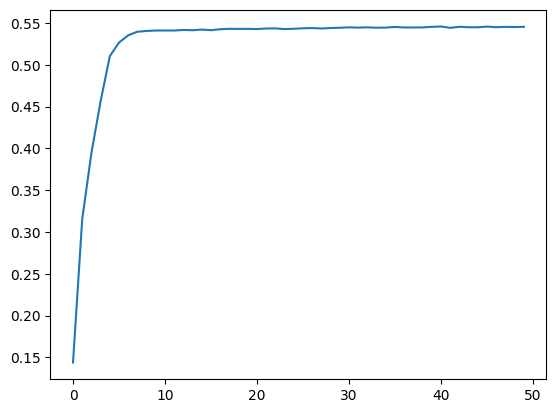

In [121]:
plt.plot(history.epoch, history.history['accuracy'], label='total loss')
plt.show()

In [122]:
y_pred = model.predict(x_test) # shape (15345, 49) <class 'numpy.ndarray'>
print(y_pred.shape)

480/480 [==============================] - 0s 440us/step
(15345, 49)


In [123]:
_SAMPLING_RATE = 16000
# make a fucntion to be able to do so
def show_and_play_midi(pianorolls: list, filename): #pianorolls shape(1,48)
  
  def make_midi(pianorolls:list, filename): #pianorolls shape (1,48)
      midi = pretty_midi.PrettyMIDI(resolution=480)
      for pianoroll in pianorolls: # each pianoroll vecotr is 'numpy.ndarray'
        instr = pretty_midi.Instrument(program=1)
        NoteCounter = 0
        for i in range(len(pianoroll)): #range(0, 48)
              # We are getting prob distribution between 0-1. Keep notes closer to 1, dump notes closer to 0
              # 0.5 is only a threshold, coud be any number between 0-1 
              if pianoroll[i] > 0.5: # check the TS note how it looks like
                NoteCounter += 1
                print("NoteCounter ",NoteCounter)
                print("Gotcha!!!!!!!", pianoroll[i])
                # print("pianoroll>0.5",pianoroll[i])
                print("i!!",i)
                instr.notes.append(pretty_midi.Note(start=0,
                                                      end=1,
                                                      pitch=36+i,
                                                  velocity=100)) 
        if NoteCounter == 0:
            import sys
            print("I'm resting!!!")
            image_url = 'https://66.media.tumblr.com/tumblr_ly327cwP6n1qhigt0o1_500.gif'
            response = requests.get(image_url)
            img_path = 'data/downloaded_image.jpg'
            with open(img_path, 'wb') as f:
                    f.write(response.content)
            display(Image(filename='data/downloaded_image.jpg'))
            sys.exit()                                       
        midi.instruments.append(instr)
      
      midi.write(filename)

  
  ##Save the midi data into a file, the file name is given in the next cell as output.midi
  make_midi(pianorolls, filename)
  for pr in pianorolls:
    pr_2d = pr.reshape(-1,1)
    plt.matshow(np.transpose(pr_2d))
    plt.show()

  # Convert MIDI to Wav so that you can listen to it on web browser
  fs = FluidSynth(sound_font="/Volumes/MAGIC1/FluidR3_GM/FluidR3_GM.sf2")
  fs.midi_to_audio("data/output.mid", "data/output.wav")

  ipd.display(ipd.Audio("data/output.wav", rate=_SAMPLING_RATE))

NoteCounter  1
Gotcha!!!!!!! 0.50533867
i!! 36


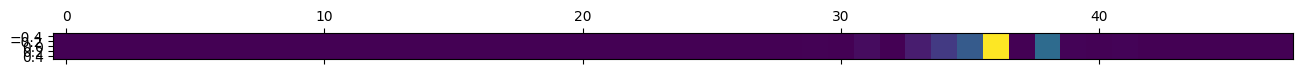

FluidSynth runtime version 2.3.2
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'data/output.wav'..


In [177]:
k = random.randint(0, len(x_test))
# print(y_pred) # <class 'numpy.ndarray'>
# print(x_test[:100, :]) 
# print(y_pred[:100,:]) # 100 is for first 100 elements.
# print(len(y_pred[k,  0:-1])) # Scalar len 48
show_and_play_midi([y_pred[k, 0:-1]],
"data/output.mid")

### Unused Code Below>>>

In [114]:
# def read_midi(filename, sop_alto, seqlen):
  
#   def get_pianoroll(midi, nn_from, nn_thru, seqlen, tempo):
#     pianoroll = midi.get_piano_roll(fs=2*tempo/60) # shape(128, 1262) This is the core line which makes this matrix based on 8th note
#     if pianoroll.shape[1] < seqlen:
#         raise UnsupportedMidiFileException

#     pianoroll = pianoroll[nn_from:nn_thru, 0:seqlen] # (48, 64) Pinoroll's value still NOT binary since it has velocity
    
#     binary_pianoroll = np.heaviside(pianoroll, 0) # converting as a binary matrix
#     transposed_pianoroll = np.transpose(binary_pianoroll) #(64, 48)
#     # transposed_pianoroll = np.transpose(pianoroll)
#     # return binary_pianoroll
#     return transposed_pianoroll # type numpy.ndarray


#   def add_rest_nodes(pianoroll):  # If all the elemets are zero, the rest node says 1, else 0
#     rests = 1 - np.sum(pianoroll, axis=1)
#     rests = np.expand_dims(rests, 1)
#     return np.concatenate([pianoroll, rests], axis=1)
  

#   # read midi file
#   midi = pretty_midi.PrettyMIDI(filename)

#   # An Exception error is thrown if there is a modulation(key change)
#   if len(midi.key_signature_changes) !=1:
#     raise UnsupportedMidiFileException

#   # Modulate the given key to C major or C minor
#   key_number = midi.key_signature_changes[0].key_number
#   # transpose_to_c(midi, key_number)

#   # Get Major key(keynode=0) or Minor key(keynode=1)
#   keymode = np.array([int(key_number / 12)])

#   # The Exception error thrown when tempo changes
#   tempo_time, tempo = midi.get_tempo_changes()
#   if len(tempo) != 1:
#     raise UnsupportedMidiFileException
#   if sop_alto:
#     # The exception thrown if there are less than 2 parts
#     if len(midi.instruments) < 2:
#       raise UnsupportedMidiFileException
    
#     # Get pianoRoll returns numpy.ndarray
#     pr_s = get_pianoroll(midi.instruments[0], nn_from=36, nn_thru=84, seqlen=seqlen, tempo=tempo[0])
#     pr_a = get_pianoroll(midi.instruments[1], nn_from=36, nn_thru=84, seqlen=seqlen, tempo=tempo[0])
#     pr_b = get_pianoroll(midi.instruments[2], nn_from=36, nn_thru=84, seqlen=seqlen, tempo=tempo[0])
    
    
#     sop_w_rest = add_rest_nodes(pr_s) 
#     alt_w_rest = add_rest_nodes(pr_a)
#     bass_w_rest = add_rest_nodes(pr_b)
    
#     # return alt_w_rest, bass_w_rest, keymode
#     return sop_w_rest, alt_w_rest, bass_w_rest, keymode # All numpy.ndarray including keymode  

#   else:
#     #Get a pianoroll which gathered all the parts
#     pr = get_pianoroll(midi, nn_from=36, nn_thru=84, seqlen=seqlen, tempo=tempo[0])
#     return pr, keymode

In [125]:
# def predict_next_note(
#         notes: np.ndarray, # x data
#         model: tf.keras.Model,
#         temperature: float = 1.0) -> tuple[int]: # -> indicates what you return
#     """Generates a note, using a trained sequence model."""
#     assert temperature > 0 
#     # Add batch dimension
#     # inputs = tf.expand_dims(notes, 0)
#     note_logits = model.predict(notes) # shape (15345, 49)
#     # print("note_logits",note_logits[:2])  # should be a 2D tensor for random.categoriacal's 1st arg. 
#     note_logits /= temperature
#     # print("note_logits temp",note_logits)
#     # print("note_logits", note_logits.shape)
#     pitch = tf.random.categorical(note_logits, num_samples=1) #random.categorical requires 2D tensor for logits
#     # print("categorical pitch",pitch)
#     pitch = tf.squeeze(pitch, axis=-1)
#     # print(f"pitch after squeezed{pitch}")
#       # print("pitch",pitch)
#     pitches = []
#     for i in pitch:
#         if 36<= i <=83:
#            # as 36 is the lowest key, adding y_pred value makes sop part
#            pitches.append(i)
#     return pitches # shape (64,)

In [126]:
# temperature = 2.0
# # input_notes = x_test[:seq_length]
# input_notes = x_test # shape (751905, 2)
# # print(y_test.shape)

# generated_notes = predict_next_note(input_notes, model, temperature)

# generated_notes = pd.DataFrame(
#     generated_notes
# )
# generated_notes.columns = ["pitch"] # Give the label to the column to access it
# generated_notes.head(10) # Using slice due to the huge data
# print(generated_notes[:100])

In [127]:
# _SAMPLING_RATE = 16000
# def display_audio(pm: pretty_midi.PrettyMIDI, seconds=40):
#     waveform = pm.fluidsynth(fs=float(_SAMPLING_RATE))
#     # Take a sample of the generated waveform to mitigate kernel resets
#     waveform_short = waveform[:seconds*_SAMPLING_RATE]
#     return display.Audio(waveform_short, rate=_SAMPLING_RATE) # this display class is from IPython

In [128]:
# def pandas_to_midi(notes:pd.DataFrame):
#     data = notes["pitch"]
#     df = pd.DataFrame(data)

#     # Convert pitch values to MIDI notes
#     notes = df['pitch'].tolist()
#     pm = pretty_midi.PrettyMIDI()
#     instrument = pretty_midi.Instrument(program=0)

#     # Add notes to the MIDI object
#     for i, note in enumerate(notes):
#         note_start = i * 0.5  # Adjust the start time as needed
#         note_end = note_start + 0.4  # Adjust the end time as needed. Make + 1.4 you can hear pedal-sustain like notes
#         midi_note = pretty_midi.Note(velocity=100, pitch=note, start=note_start, end=note_end)
#         instrument.notes.append(midi_note)

#     pm.instruments.append(instrument)
    
#     return pm

In [129]:
# pm = pandas_to_midi(generated_notes)

# # Display audio using your function
# display_audio(pm)


In [130]:
# def get_pianoroll(midi, nn_from, nn_thru, seqlen, tempo):
#     pianoroll = midi.get_piano_roll(fs=2*tempo/60) # This is the core line which makes this matrix based on 8th note
#     print(f"pianoroll shape[1] in getPiano roll:{pianoroll.shape[1]}")

#     if pianoroll.shape[1] < seqlen:
#         raise UnsupportedMidiFileException

#     pianoroll = pianoroll[nn_from:nn_thru, 0:seqlen] # (48, 64) Pinoroll's value still NOT binary since it has velocity
    
#     binary_pianoroll = np.heaviside(pianoroll, 0) # converting as a binary matrix
#     transposed_pianoroll = np.transpose(binary_pianoroll) #(64, 48)
#     # transposed_pianoroll = np.transpose(pianoroll)
#     # return binary_pianoroll
#     return transposed_pianoroll # type numpy.ndarray

In [131]:
"""faled model"""
# # Assuming the shapes you've provided: x_train, x_test, y_train, y_test

# # Create an LSTM model
# model = tf.keras.Sequential()

# # Add an LSTM layer
# model.add(tf.keras.layers.LSTM(units=64, input_shape=(2, 1)))  # LSTM units can be adjusted based on the complexity of the problem

# # Add a dense layer for output
# model.add(tf.keras.layers.Dense(1, activation='softmax'))  # Adjust the output shape based on your targets

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.evaluate(x_train, y_train, return_dict=True)

# # Train the model
# model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))



'faled model'

In [132]:
# seq_length = x_train.shape[1] # 2 -> 時系列の長さ(時間方向の要素数)
# input_dim = x_train.shape[2] # 64 -> 入力の各要素の次元数
# output_dim = y_train.shape[2] # 47-> 出力の各要素の次元数

In [133]:
# """get inputs (Xn, Xn+1) and target (Xn+2) """
# def make_sequences(
#         dataset: tf.data.Dataset,
#         seq_length:int,
# ) -> tf.data.Dataset:
    
#     seq_length = seq_length+1

#     windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)
#     # for w in windows:
#     #    print(f"window!! {list(w.as_numpy_iterator())}")
    
#     flatten = lambda x: x.batch(seq_length, drop_remainder=True) # Assing lambda function to the variable "flatten"
#     sequences = windows.flat_map(flatten) # Flat_map falltens the "dataset of datasets" into a dataset of tensors

#     def split_labels(sequences):
#         inputs = sequences[:-1] # Could not see the inside as this func got in through map_func
#         output_dense = sequences[-1]
#         return inputs, output_dense
    
#     return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [134]:
# sop_tf_data = [] #  A list which contains (64 ,49) tf.daset elements
# sop, alt, bass, keymode = read_midi(f, True, 64)
# # sop = sop[0]
# # sop_tf = tf.data.Dataset.from_tensor_slices(sop)
# # print(list(sop_tf.as_numpy_iterator()))

# for i in sop:
#     sop_tf = tf.data.Dataset.from_tensor_slices(i)
#     sop_tf_data.append(sop_tf)

# # for t in sop_tf_data:
#     # print(list(t.as_numpy_iterator()))


In [135]:
# single_sop_tf = sop_tf_data[0]
# seq_length = 2
# # print(make_sequences(single_sop_tf, seq_length))

# seq_ds = make_sequences(single_sop_tf, seq_length) # 47 elements each input n output
# # type <'tensorflow _ParallelMapDataset'>
# # print(seq_ds.element_spec)
# # print(list(seq_ds.as_numpy_iterator())) # [(array([0., 0.]), 0.0), (array([0., 0.]), 0.0)...


# inputList = []
# targetList = []

# #<Check the dataset elements>
# for seq, target in seq_ds:
#   # print('Input sequence shape:', seq.shape) # shape (2,), a one-dimensional array (vector) with a length of 2.
#   # print('Input sequence elements:', seq[0: 1]) 
#   # print('target:', target) # shape ()
#   # print()
#   inputList.append(seq) # <class 'list'>
#   targetList.append(target) # <class 'list'>

# inputList = np.array(inputList) # <class 'numpy.ndarray'>. shape (47, 2), 2D matrix
# targetList = np.array(targetList) # <class 'numpy.ndarray'> shape (47,), 1D scalar

In [136]:
# from midi2audio import FluidSynth
# from IPython.display import Audio

# songFileName = "output"

# #Convert MIDI to audio using FluidSynth
# fs = FluidSynth(sound_font="/Volumes/MAGIC1/FluidR3_GM/FluidR3_GM.sf2")
# # fs = FluidSynth(sound_font="/usr/share/sounds/sf2/FluidR3_GM.sf2")
# fs.midi_to_audio(f'data/{songFileName}.mid', f'data/{songFileName}.wav')

# #Display the audio in the notebook
# ipd.display(ipd.Audio(f"data/{songFileName}.wav", rate=_SAMPLING_RATE))

In [137]:
"""Try to get sound from y_pred"""
# midi = pretty_midi.PrettyMIDI(resolution=480)
# # print(len(y_pred))
# for test in y_pred:
#     instr = pretty_midi.Instrument(program=1)
#     print(test)

'Try to get sound from y_pred'

In [138]:
"""The custom window test"""
# testListX = []
# testListY = []


# data = [["apple", "banana", "peach"], ["choco", "pineapple", "melon"], ["avocado", "pizza", "sushi"], ["car", "taxi", "bus"], ["cat", 'dog', 'pig']]
# for i in range(len(data)-2): 
#     input_test = data[i:i+2]
#     output_test = data[i+2]
#     # print("--input--")
#     # print(input_test)
#     # print("--output--")
#     # print(output_test)
#     testListX.append(input_test)
#     testListY.append(output_test)

# input_dataTest = np.array(testListX) 
# output_dataTest = np.array(testListY)

# print("input_dataTest", input_dataTest)
# print("output_dataTest", output_dataTest)
# print("input_dataTest Shape", input_dataTest.shape)
# print("output_dataTest Shape", output_dataTest.shape)


'The custom window test'

In [139]:
"""Investigte what y_pred[k, :, 0:-1] does in kthrPiano book"""

# data1 = [[[10,20,30],[40,50,60]], [[100,200,300],[400,500,600]], 
#          [[1000,2000,3000],[4000,5000,6000]]]
# data1 = np.array(data1)
# print(data1)

# data1[2, :, :-1]

'Investigte what y_pred[k, :, 0:-1] does in kthrPiano book'